In [1]:
import numpy as np
import torch
import pandas as pd
import os

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset

from PIL import Image
from torchvision import transforms

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

In [2]:
if torch.cuda.is_available():
    print(f"CUDA is available. Device: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. Training will be on the CPU.")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

CUDA is available. Device: NVIDIA RTX A3000 Laptop GPU
Using device: cuda


In [3]:
def hist_train_data(d_values, fractal_types, bins=20, stacked=False):
    # Create a DataFrame from the provided d_values and fractal_types
    data = pd.DataFrame({
        'd_value': d_values,
        'fractal_type': fractal_types
    })

    unique_types = data['fractal_type'].unique()
    plt.figure(figsize=(10, 6))

    # Prepare the list of d_values for each fractal type
    hist_data = [data[data['fractal_type'] == ftype]['d_value'] for ftype in unique_types]

    # Compute consistent bins across all fractal types
    min_val = np.min(d_values)
    max_val = np.max(d_values)
    bin_edges = np.linspace(min_val, max_val, bins + 1)

    if stacked:
        # Plot stacked histogram
        plt.hist(
            hist_data,
            bins=bin_edges,  # Use consistent bin edges
            stacked=True,
            alpha=0.7,
            label=[str(ftype) for ftype in unique_types],
            edgecolor='black'
        )
        plt.title('Stacked Histogram of D-values Used in Training by Fractal Type')
    else:
        # Plot histograms side by side (overlay with transparency)
        for idx, ftype in enumerate(unique_types):
            plt.hist(
                hist_data[idx],
                bins=bin_edges,  # Use consistent bin edges
                alpha=0.5,
                label=str(ftype),
                edgecolor='black'
            )
        plt.title('Histogram of D-values Used in Training by Fractal Type')

    plt.xlabel('D-value')
    plt.ylabel('Frequency')
    plt.legend(title='Fractal Type')
    plt.grid(True)
    plt.show()


def scatter_test_error(true_values, errors, fractal_types):

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=true_values, y=errors, hue=fractal_types, palette='viridis')
    plt.title('Absolute Errors vs. True Fractal Dimensions')
    plt.xlabel('True Fractal Dimension')
    plt.ylabel('Absolute Error')
    plt.legend(title='Fractal Type')
    plt.grid(True)
    plt.show()


def hist_test_error_type(errors, fractal_types, bins=20, stacked=False):
    plt.figure(figsize=(10, 6))
    unique_types = np.unique(fractal_types)
    colors = plt.cm.tab10.colors  # Color map for different categories

    # Prepare a list to hold errors for each fractal type
    hist_data = [errors[fractal_types == ftype] for ftype in unique_types]

    # Compute consistent bins based on all the data combined
    min_val = np.min(errors)
    max_val = np.max(errors)
    bin_edges = np.linspace(min_val, max_val, bins + 1)  # Bin edges are consistent

    if stacked:
        # Plot stacked histogram
        plt.hist(
            hist_data, 
            bins=bin_edges,  # Use precomputed consistent bins
            stacked=True, 
            color=[colors[idx % len(colors)] for idx in range(len(unique_types))],
            label=[str(ftype) for ftype in unique_types],
            edgecolor='black'
        )
        plt.title('Stacked Histogram of Prediction Errors by Fractal Type')
    else:
        # Plot histograms side by side (overlay with transparency) with consistent bins
        for idx, ftype in enumerate(unique_types):
            plt.hist(
                hist_data[idx],
                bins=bin_edges,  # Use precomputed consistent bins
                alpha=0.5,
                color=colors[idx % len(colors)],
                label=str(ftype),
                edgecolor='black'
            )
        plt.title('Histogram of Prediction Errors by Fractal Type')

    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.legend(title='Fractal Type')
    plt.grid(True)
    plt.show()


def hist_test_error_D(true_values, errors, d_bins=None, error_bins=20, stacked=False):   
    # If no d_bins provided, create them based on the range of true_values
    if d_bins is None:
        d_bins = np.linspace(1, 2, num=5)
    
    # Digitize the true values to assign them to D value bins
    d_bin_indices = np.digitize(true_values, bins=d_bins)
    
    # Compute consistent bins for the errors based on the entire range of errors
    min_error = np.min(errors)
    max_error = np.max(errors)
    error_bin_edges = np.linspace(min_error, max_error, error_bins + 1)  # Consistent bin edges

    plt.figure(figsize=(10, 6))

    # Prepare data for each D bin range
    hist_data = [errors[d_bin_indices == idx] for idx in range(1, len(d_bins))]

    if stacked:
        # Stacked histogram
        plt.hist(
            hist_data,
            bins=error_bin_edges,  # Use consistent error bins
            stacked=True,  # Stack the histograms
            alpha=0.7,
            label=[f'D in [{d_bins[idx-1]:.2f}, {d_bins[idx]:.2f}]' for idx in range(1, len(d_bins))],
            edgecolor='black'
        )
        plt.title('Stacked Histogram of Prediction Errors by D Value Ranges')
    else:
        # Overlaid histograms (non-stacked)
        for idx in range(1, len(d_bins)):
            plt.hist(
                hist_data[idx-1],
                bins=error_bin_edges,  # Use consistent error bins
                alpha=0.5,
                label=f'D in [{d_bins[idx-1]:.2f}, {d_bins[idx]:.2f}]',
                edgecolor='black'
            )
        plt.title('Histogram of Prediction Errors by D Value Ranges')

    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.legend(title='D Value Range')
    plt.grid(True)
    plt.show()


def display_train_results(n_epochs, train_loss_values, train_mae_values, val_loss_values, val_mae_values):
    
    num_epochs = n_epochs

    plt.figure(figsize=(15,11))

    plt.subplot(2,2,1)
    plt.plot(range(1, num_epochs + 1), train_loss_values, marker='o')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.subplot(2,2,2)
    plt.plot(range(1, num_epochs + 1), train_mae_values, marker='o')
    plt.title('Training MAE Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.grid(True)


    plt.subplot(2,2,3)
    plt.plot(range(1, num_epochs + 1), val_loss_values, marker='o')
    plt.title('Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.subplot(2,2,4)
    plt.plot(range(1, num_epochs + 1), val_mae_values, marker='o')
    plt.title('Validation MAE Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.grid(True)

In [5]:
class FractalDataset(Dataset):
    def __init__(self, image_dir, label_file, transform=None):
        self.image_dir = image_dir
        self.labels = pd.read_csv(label_file)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.labels.iloc[idx, 0])
        image = Image.open(img_name).convert('L')  # Convert to grayscale
        d_value = torch.tensor(self.labels.iloc[idx, 1], dtype=torch.float32)
        fractal_type = self.labels.iloc[idx, 2]    # Assuming fractal type is in the third column

        if self.transform:
            image = self.transform(image)

        return image, d_value, fractal_type


class FractalCNN(nn.Module):
    def __init__(self):
        super(FractalCNN, self).__init__()
        # Convolutional layers with varying kernel sizes and dilations
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=7, dilation=4)
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization after conv1
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, dilation=3)
        self.bn2 = nn.BatchNorm2d(64)  # Batch normalization after conv2
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, dilation=2)
        self.bn3 = nn.BatchNorm2d(128)  # Batch normalization after conv3

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Adaptive average pooling to handle variable input sizes
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        # Fully connected layers
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
        # First convolutional block
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)

        # Second convolutional block
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)

        # Third convolutional block
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)

        # Adaptive average pooling
        x = self.avgpool(x)

        # Flatten the tensor for the fully connected layer
        x = x.view(-1, 128 * 7 * 7)
        x = self.dropout(x)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # Output layer without activation function (regression task)
        return x


def create_balanced_loaders(
    image_dir,
    labels_dir,
    transform,
    d_ranges,
    total_samples,
    batch_size,
    val_split=0.2,
    shuffle=True,
    num_workers=4,
    pin_memory=True
):
    """
    Creates DataLoaders for training and validation with a balanced distribution of D values.

    Parameters:
    - image_dir (str): Path to the directory containing images.
    - labels_dir (str): Path to the CSV file containing labels.
    - transform (torchvision.transforms): Transformations to apply to the images.
    - d_ranges (list of dict): List of dictionaries specifying D value ranges and target proportions.
    - total_samples (int): Total number of samples to include across both DataLoaders.
    - batch_size (int): Number of samples per batch to load.
    - val_split (float): Proportion of data to use for validation.
    - shuffle (bool): Whether to shuffle the data (applies to training DataLoader).
    - num_workers (int): Number of subprocesses to use for data loading.
    - pin_memory (bool): Whether to pin memory during data loading.

    Returns:
    - train_loader (DataLoader): DataLoader with the balanced training dataset.
    - val_loader (DataLoader): DataLoader with the balanced validation dataset.
    """
    # Read the labels CSV into a DataFrame
    labels_df = pd.read_csv(labels_dir)

    # Calculate number of samples per range
    for d_range in d_ranges:
        d_range['n_samples'] = int(total_samples * d_range['proportion'])
        d_range['n_train_samples'] = int(d_range['n_samples'] * (1 - val_split))
        d_range['n_val_samples'] = d_range['n_samples'] - d_range['n_train_samples']

    train_indices = []
    val_indices = []

    for d_range in d_ranges:
        # Filter the DataFrame for the current D value range
        range_df = labels_df[
            (labels_df['d_value'] >= d_range['min']) &
            (labels_df['d_value'] < d_range['max'])
        ]

        # Check if enough samples are available
        available_samples = len(range_df)
        required_samples = d_range['n_samples']

        if available_samples < required_samples:
            print(f"Not enough samples in range {d_range['min']} - {d_range['max']}. Using all available samples ({available_samples}).")
            required_samples = available_samples
            # Adjust train and validation samples accordingly
            d_range['n_train_samples'] = int(required_samples * (1 - val_split))
            d_range['n_val_samples'] = required_samples - d_range['n_train_samples']

        # Shuffle the indices
        range_indices = range_df.index.tolist()
        np.random.seed(42)  # For reproducibility
        np.random.shuffle(range_indices)

        # Split the indices into training and validation
        n_train = d_range['n_train_samples']
        n_val = d_range['n_val_samples']

        sampled_train_indices = range_indices[:n_train]
        sampled_val_indices = range_indices[n_train:n_train + n_val]

        train_indices.extend(sampled_train_indices)
        val_indices.extend(sampled_val_indices)

    # Create a FractalDataset instance
    full_dataset = FractalDataset(
        image_dir=image_dir,
        label_file=labels_dir,
        transform=transform
    )

    # Create Subsets for training and validation
    train_subset = Subset(full_dataset, train_indices)
    val_subset = Subset(full_dataset, val_indices)

    # Create the DataLoaders
    train_loader = DataLoader(
        train_subset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=pin_memory
    )

    val_loader = DataLoader(
        val_subset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory
    )

    return train_loader, val_loader


def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    model.to(device)  # Move model to the appropriate device

    train_loss_values = []
    train_mae_values = []
    val_loss_values = []
    val_mae_values = []

    used_d_values = []   # List to store d-values used in training
    used_fractal_types = []  # List to store fractal types

    for epoch in tqdm(range(num_epochs)):
        # Training Phase
        model.train()  # Set the model to training mode
        epoch_train_loss = 0.0
        epoch_train_mae = 0.0

        for images, labels, fractal_types in train_loader:
            images = images.to(device)
            labels = labels.to(device).unsqueeze(1)  # Shape: [batch_size, 1]

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate loss and MAE
            batch_size = images.size(0)
            epoch_train_loss += loss.item() * batch_size
            epoch_train_mae += torch.sum(torch.abs(outputs - labels)).item()

            used_d_values.extend(labels.cpu().numpy().flatten())
            used_fractal_types.extend(fractal_types)

        # Calculate average loss and MAE for the epoch
        avg_train_loss = epoch_train_loss / len(train_loader.dataset)
        avg_train_mae = epoch_train_mae / len(train_loader.dataset)

        train_loss_values.append(avg_train_loss)
        train_mae_values.append(avg_train_mae)

        # Validation Phase
        model.eval()  # Set the model to evaluation mode
        epoch_val_loss = 0.0
        epoch_val_mae = 0.0

        with torch.no_grad():
            for images, labels, fractal_types in val_loader:
                images = images.to(device)
                labels = labels.to(device).unsqueeze(1)

                outputs = model(images)
                loss = criterion(outputs, labels)

                # Accumulate loss and MAE
                batch_size = images.size(0)
                epoch_val_loss += loss.item() * batch_size
                epoch_val_mae += torch.sum(torch.abs(outputs - labels)).item()

                used_d_values.extend(labels.cpu().numpy().flatten())
                used_fractal_types.extend(fractal_types)

        # Calculate average loss and MAE for the validation set
        avg_val_loss = epoch_val_loss / len(val_loader.dataset)
        avg_val_mae = epoch_val_mae / len(val_loader.dataset)

        val_loss_values.append(avg_val_loss)
        val_mae_values.append(avg_val_mae)

        # Print epoch metrics
        print(f'Epoch [{epoch+1}/{num_epochs}]: '
                f'Train Loss: {avg_train_loss:.4f}, Train MAE: {avg_train_mae:.4f} ||'
                f'Val Loss: {avg_val_loss:.4f}, Val MAE: {avg_val_mae:.4f}')
               

    results = {
        'average train loss': avg_val_loss,
        'average train mae': avg_val_mae,
        'train loss values': np.array(train_loss_values).squeeze(),
        'train mae values': np.array(train_mae_values).squeeze(),
        'val loss values': np.array(val_loss_values).squeeze(),
        'val mae values': np.array(val_mae_values).squeeze(),
        'average val loss': avg_val_loss,
        'average val mae': avg_val_mae,
        'fractal types': used_fractal_types,
        'd values': np.array(used_d_values).squeeze(),
        } 
    
    return(results)


def test_model(model, test_loader, criterion):
    
    model.eval()  
    
    test_loss = 0.0
    test_mae = 0.0

    predictions = []
    true_values = []
    fractal_types = []  

    with torch.no_grad():
        for images, labels, fractal_type in tqdm(test_loader):
            images = images.to(device)
            labels = labels.to(device).unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            batch_size = images.size(0)
            
            # Accumulate loss and MAE
            test_loss += loss.item() * batch_size
            test_mae += torch.sum(torch.abs(outputs - labels)).item()

            predictions.extend(outputs.cpu().numpy())
            true_values.extend(labels.cpu().numpy())
            fractal_types.extend(fractal_type)      

    # Calculate average loss and MAE
    avg_test_loss = test_loss / len(test_loader.dataset)
    avg_test_mae = test_mae / len(test_loader.dataset)

    errors = np.abs(np.array(predictions) - np.array(true_values))
    
    # Print summary
    print(f'Test Loss: {avg_test_loss:.4f} || Test MAE: {avg_test_mae:.4f}')

    # Return results in dictionary form
    results = {
        'test loss': avg_test_loss,
        'test mae': avg_test_mae,
        'predictions': np.array(predictions).squeeze(),
        'true values': np.array(true_values).squeeze(),
        'fractal types': fractal_types,
        'errors': np.array(errors).squeeze(),
    }

    return results

In [8]:
image_dir = r'/home/apd/Projects/FractalFluency/datasets/first_batch'
labels_dir = r'/home/apd/Projects/FractalFluency/datasets/first_batch/labels.csv'

transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize all images to 512x512
    transforms.ToTensor(),          # Convert PIL images to tensors
    transforms.Normalize((0.5,), (0.5,))
])

d_ranges = [
    {'min': 1.2, 'max': 1.4, 'proportion': 0.25},
    {'min': 1.4, 'max': 1.6, 'proportion': 0.50},
    {'min': 1.6, 'max': 1.8, 'proportion': 0.25}
]

total_samples = 1000
batch_size = 50
val_split = 0.2 
n_epochs = 10


train_loader, val_loader = create_balanced_loaders(
    
    image_dir=image_dir,
    labels_dir=labels_dir,
    transform=transform,
    d_ranges=d_ranges,
    total_samples=total_samples,
    batch_size=batch_size,
    val_split=val_split,
    shuffle=True,
    num_workers=8,
    pin_memory=True
)


model_0 = FractalCNN().to(device)
criterion = nn.L1Loss()
optimizer = optim.Adam(model_0.parameters(), lr=0.001)

results = train_model(model_0, train_loader=train_loader, 
                            val_loader=val_loader, 
                            criterion = criterion, 
                            optimizer = optimizer, 
                            num_epochs=n_epochs)


avg_train_loss = results['average train loss']
avg_train_mae = results['average train mae']
train_loss_values = results['train loss values']
train_mae_values = results['train mae values']
val_loss_values = results['val loss values']
val_mae_values = results['val mae values']
avg_val_loss = results['average val loss']
avg_val_mae = results['average val mae']

fractal_types = results['fractal types']
d_values = results['d values']



Not enough samples in range 1.6 - 1.8. Using all available samples (116).


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10]: Train Loss: 2.5068, Train MAE: 2.5068 ||Val Loss: 1.2660, Val MAE: 1.2660
Epoch [2/10]: Train Loss: 0.6470, Train MAE: 0.6470 ||Val Loss: 0.4059, Val MAE: 0.4059
Epoch [3/10]: Train Loss: 0.2574, Train MAE: 0.2574 ||Val Loss: 0.3867, Val MAE: 0.3867
Epoch [4/10]: Train Loss: 0.1239, Train MAE: 0.1239 ||Val Loss: 0.2127, Val MAE: 0.2127
Epoch [5/10]: Train Loss: 0.0833, Train MAE: 0.0833 ||Val Loss: 0.0989, Val MAE: 0.0989
Epoch [6/10]: Train Loss: 0.0621, Train MAE: 0.0621 ||Val Loss: 0.0884, Val MAE: 0.0884
Epoch [7/10]: Train Loss: 0.0506, Train MAE: 0.0506 ||Val Loss: 0.0578, Val MAE: 0.0578
Epoch [8/10]: Train Loss: 0.0434, Train MAE: 0.0434 ||Val Loss: 0.0454, Val MAE: 0.0454
Epoch [9/10]: Train Loss: 0.0446, Train MAE: 0.0446 ||Val Loss: 0.0550, Val MAE: 0.0550
Epoch [10/10]: Train Loss: 0.0504, Train MAE: 0.0504 ||Val Loss: 0.0291, Val MAE: 0.0291


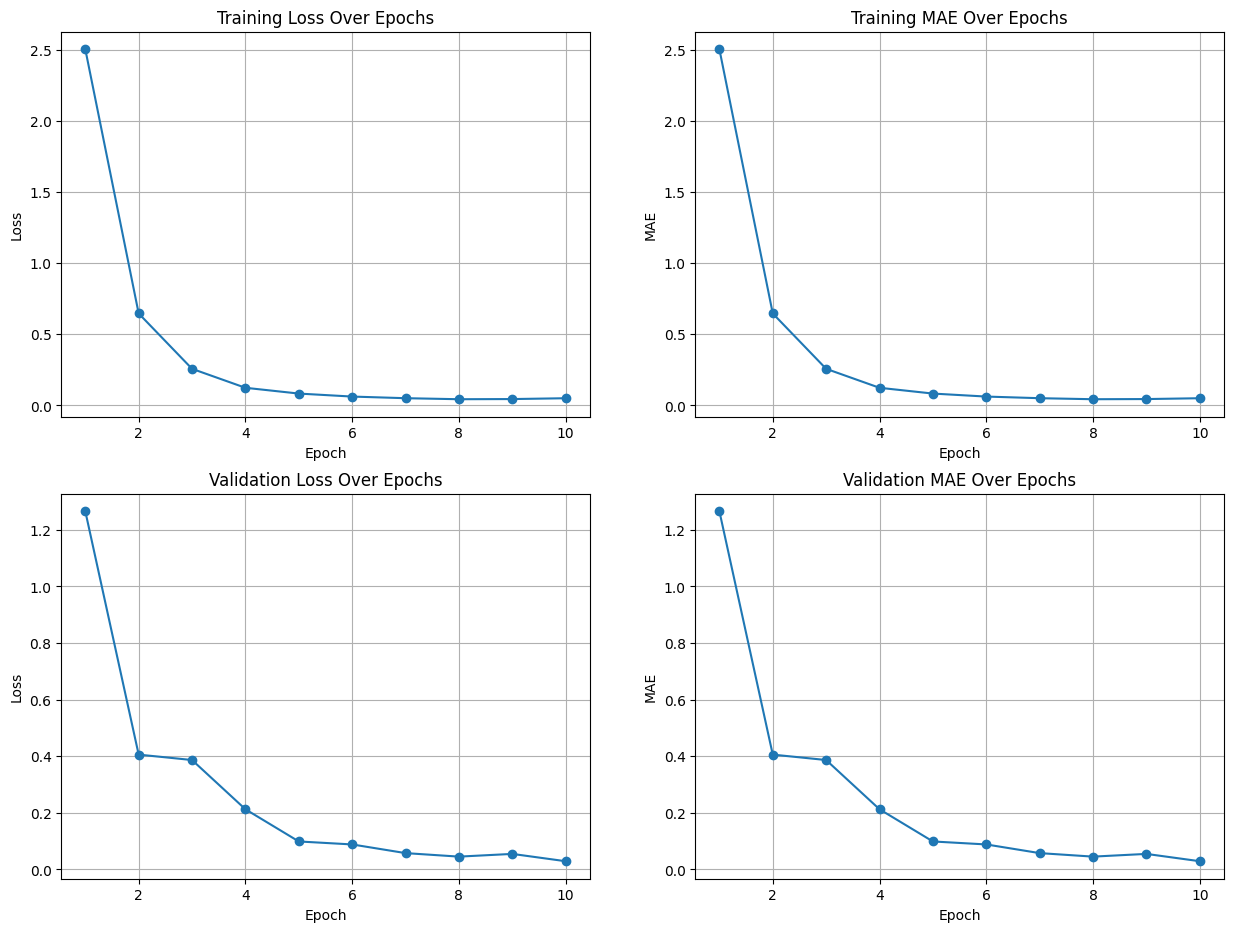

In [9]:
display_train_results(n_epochs = n_epochs,
                      train_loss_values = train_loss_values, 
                      train_mae_values =train_mae_values, 
                      val_loss_values = val_loss_values, 
                      val_mae_values = val_mae_values)

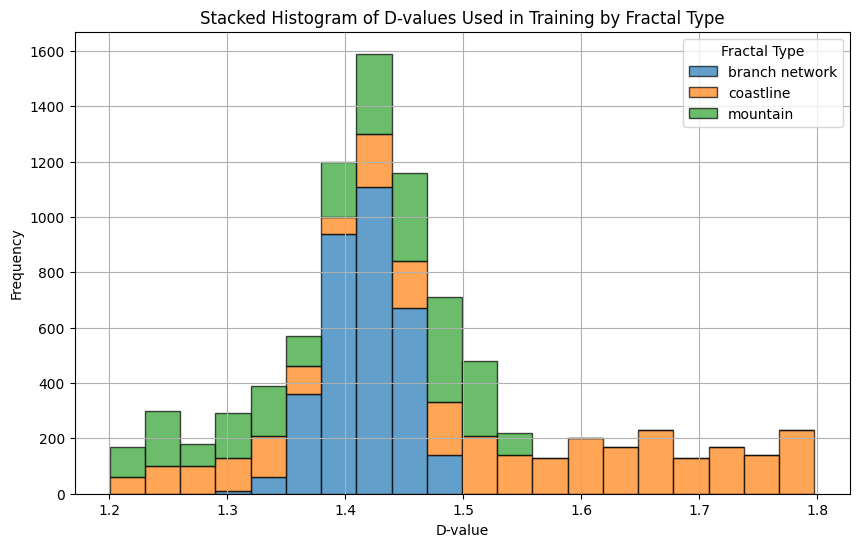

In [10]:
hist_train_data(d_values = d_values, fractal_types = fractal_types, stacked=True)

In [11]:
test_image_dir = r'/home/apd/Projects/FractalFluency/datasets/first_batch'
test_labels_dir = r'/home/apd/Projects/FractalFluency/datasets/first_batch/labels.csv'

test_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

test_dataset = FractalDataset(image_dir=test_image_dir, label_file=test_labels_dir, transform=test_transform)
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=8,         
    pin_memory=True        
)

criterion = nn.L1Loss()

results = test_model(model = model_0, test_loader=test_loader, criterion=criterion)

avg_loss = np.array(results['test loss'])
avg_mae = np.array(results['test mae'])
predictions = np.array(results['predictions'])
true_values = np.array(results['true values'])
fractal_types = np.array(results['fractal types'])
errors = np.array(results['errors'])

  0%|          | 0/47 [00:00<?, ?it/s]

Test Loss: 0.0437 || Test MAE: 0.0437


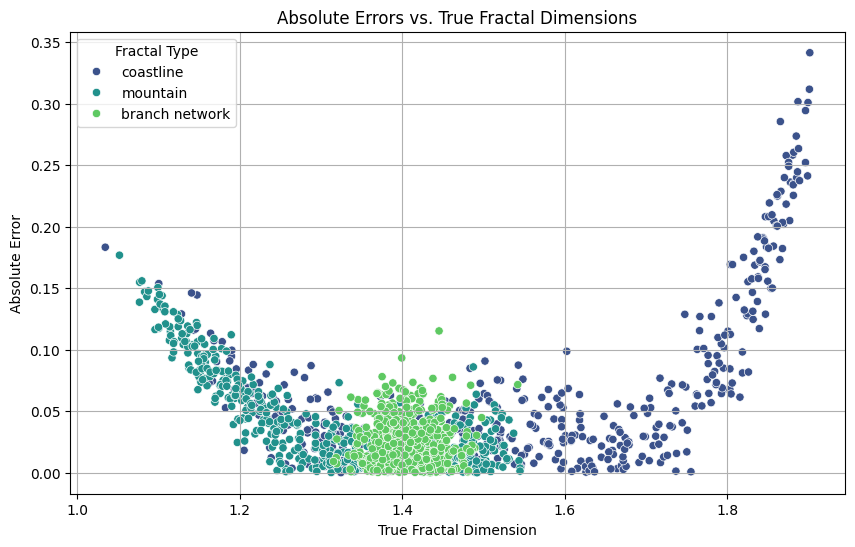

In [12]:
scatter_test_error(true_values, errors, fractal_types)

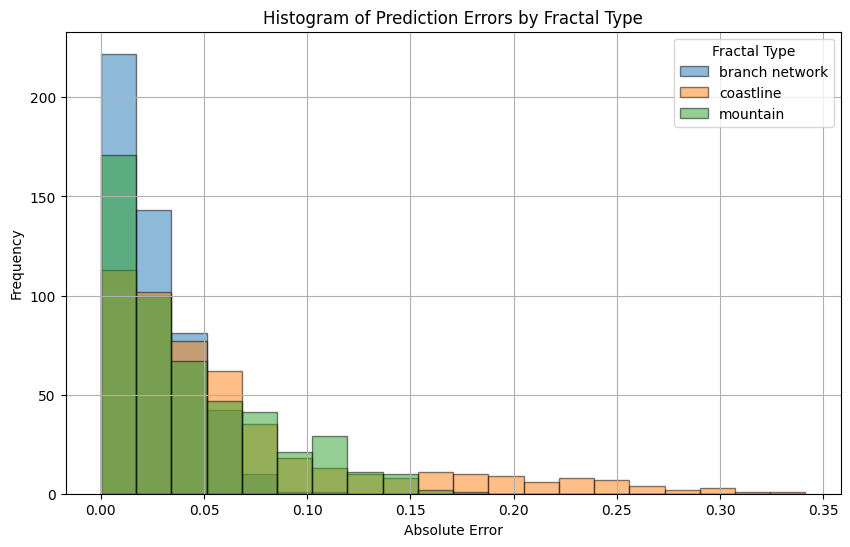

In [14]:
hist_test_error_type(errors, fractal_types, stacked=False)

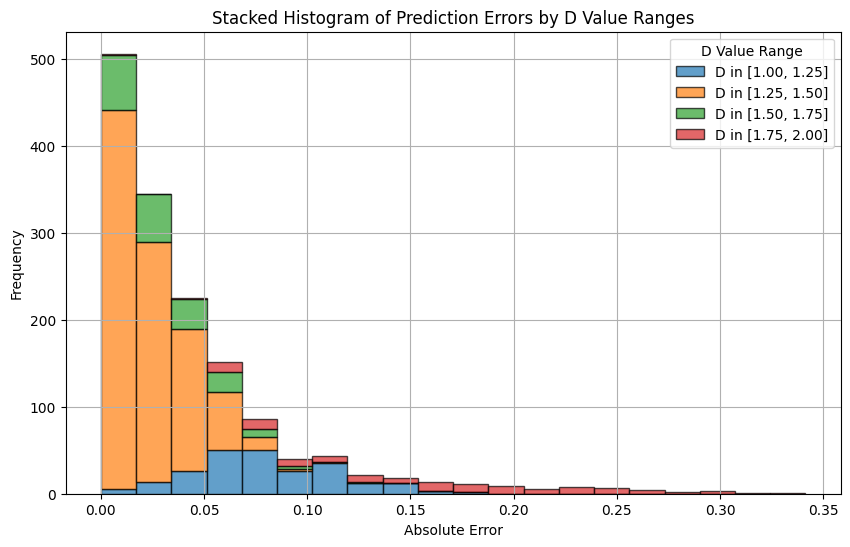

In [15]:
hist_test_error_D(true_values, errors, stacked=True)

things to do :::::::


Hist data D values going into model: YUP

hist test data used for evalutation: YUP

^^^^ For these make them stack vertically not horizontally (on top not see through): YUP

find way to force proportions of D values for training data

moer fractal types

actually learn the art of ML
?????

profit